# <center>Проект: "Идентификация пользователей по посещенным веб-страницам".</center>

## 1. Описание проекта. 

В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. Мы будем решать похожую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).
   

In [55]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import numpy as np
import pandas as pd
import itertools
import pickle
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import datetime

from tqdm import tqdm

from scipy import stats as sts
from statsmodels.stats.proportion import proportion_confint
from itertools import combinations
from time import time
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import learning_curve
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBClassifier
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from scipy import sparse, stats
from collections import Counter

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
PATH_TO_DATA = 'capstone_user_identification'

###  Подготовка данных к анализу и построению моделей.

Поставим задачу классификации: идентифицировать пользователя по сессии из 10 подряд посещенных сайтов. Объектом в этой задаче будет сессия из 10 сайтов, последовательно посещенных одним и тем же пользователем, признаками – индексы этих 10 сайтов (чуть позже здесь появится "мешок" сайтов, подход Bag of Words). Целевым классом будет id пользователя.

### Подготовка обучающей выборки

Реализуем функцию prepare_train_set, которая принимает на вход путь к каталогу с csv-файлами path_to_csv_files и параметр session_length – длину сессии, а возвращает 2 объекта:

* DataFrame, в котором строки соответствуют уникальным сессиям из session_length сайтов, session_length столбцов – индексам этих session_length сайтов и последний столбец – ID пользователя
* частотный словарь сайтов вида {'site_string': [site_id, site_freq]}, например для недавнего игрушечного примера это будет {'vk.com': (1, 2), 'google.com': (2, 2), 'yandex.ru': (3, 3), 'facebook.com': (4, 1)}

In [3]:
def prepare_train_set(path_to_csv_files, session_length=10):
    site_freq = {}
    next_user_id = 1
    
    headers_dict = ['site' + str(idx) for idx in range(1, session_length + 1)] + ['user_id']
    
    df = pd.DataFrame(columns=headers_dict)
    
    for file in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):

        sites = pd.read_csv(file).site.values
        
        session_count = int(len(sites) / session_length) + (1 if (len(sites) % session_length) != 0 else 0)

        for s in sites:
            if s not in site_freq:
                site_freq[s] = [len(site_freq) + 1, 0]

            site_freq[s][1] += 1

        sessions = [[site_freq[s][0] for s in sites[idx * session_length : idx * session_length + session_length]] for idx in range(session_count)]

        last_idx = len(sessions) - 1

        if(len(sessions[last_idx]) < session_length):
            sessions[last_idx] = sessions[last_idx] + [0] * (session_length - len(sessions[last_idx]))
        
        row_dict = {'site' + str(idx + 1): l for idx, l in enumerate(np.array(sessions).transpose())}
        row_dict['user_id'] = [next_user_id] * len(sessions)
            
        temp_df = pd.DataFrame(row_dict)

        df = df.append(temp_df, ignore_index=True)
    
        next_user_id = next_user_id + 1
    df = df[headers_dict]
    
    return df, site_freq

Применим полученную функцию к данным по 10 и 150 пользователями и сохраним полученные DataFrame в csv-файлы для дальнейшего анализа.

In [14]:
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, '10users'))
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users'))

100%|████████████████████████████████████████| 150/150 [00:10<00:00, 14.37it/s]


In [15]:
train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 
                                       'train_data_10users.csv'), 
                        index_label='session_id', float_format='%d')
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 
                                        'train_data_150users.csv'), 
                         index_label='session_id', float_format='%d')

Для 10 пользователей количество уникальных сайтов составило **4913** сайтов, а для 150 - **27797**.
В топ-10 самых популярных сайтов среди посещенных 150 пользователями  **НЕ** входит safebrowsing-cache.google.com.

### Работа с разреженным форматом данных

Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$. Делать это будем с помощью разреженных матриц Scipy – [csr_matrix]

In [17]:
def get_dense_matrix(matrix):
    site_ids = prepare_site_list(matrix)
    X = matrix
    
    i = 0
    data = list()
    col = list()
    rows = list()
    for row in tqdm(X):
        unique, counts = np.unique(row, return_counts=True)
        dic = dict(zip(unique, counts))
        for k in dic:
            if k == 0:
                continue
            
            data.append(dic[k])
            rows.append(i)
            col.append(k-1)
            
        i += 1
    X_sparse = csr_matrix((data, (rows, col)), shape=(X.shape[0], len(site_ids)))
    return X_sparse

In [20]:
def prepare_site_list(matrix):
    return set(el for row in matrix for el in row if el != 0)

In [21]:
X_10users, y_10users = train_data_10users.iloc[:, :-1].values, \
                       train_data_10users.iloc[:, -1].values
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, \
                         train_data_150users.iloc[:, -1].values

In [22]:
X_sparse_10users = get_dense_matrix(X_10users)
X_sparse_150users = get_dense_matrix(X_150users)

100%|███████████████████████████████| 137019/137019 [00:06<00:00, 19927.14it/s]


**Сохраним эти разреженные матрицы с помощью [pickle](https://docs.python.org/2/library/pickle.html) (сериализация в Python), также сохраним вектора *y_10users, y_150users* – целевые значения (id пользователя)  в выборках из 10 и 150 пользователей.

In [24]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'wb') as X10_pkl:
    pickle.dump(X_sparse_10users, X10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'wb') as y10_pkl:
    pickle.dump(y_10users, y10_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'wb') as X150_pkl:
    pickle.dump(X_sparse_150users, X150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'wb') as y150_pkl:
    pickle.dump(y_150users, y150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

## 2. Подготовка и первичный анализ данных.

### Подготовка нескольких обучающих выборок для сравнения

Cделаем число сайтов в сессии параметром, чтоб в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь давайте применим идею скользящего окна – сессии будут перекрываться.
Реализуем функцию *prepare_sparse_train_set_window* которая должна возвращать 2 объекта:
- разреженную матрицу *X_sparse* (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из *session_length* сайтов, а *max(site_id)* столбцов – количеству посещений *site_id* в сессии. 
- вектор *y* (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из *X_sparse*



In [28]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    with (open(site_freq_path, 'rb')) as file:
        site_freq = pickle.load(file)  
    next_user_id = 1
    users = []
    rows = []
    for file in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):
        sites = pd.read_csv(file).site.values        
        session_count = int(len(sites) / window_size) + (1 if (len(sites) % window_size) != 0 else 0)
        sessions = [[site_freq[s][0] for s in sites[idx * window_size : idx * window_size + session_length]] for idx in range(session_count)]
        for idx in range(len(sessions) - 1,-1,-1):
            if(len(sessions[idx]) < session_length):
                sessions[idx] = sessions[idx] + [0] * (session_length - len(sessions[idx]))
            else:
                break
        users.extend([next_user_id] * len(sessions))
        rows.extend(sessions)
        next_user_id = next_user_id + 1 
    return get_dense_matrix(np.array(rows)), users

Запустим функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра session_length (15, 10, 7 или 5) и значениям параметра window_size (10, 7 или 5). 

### Первичный анализ данных, проверка гипотез

Считаем в DataFrame файл train_data_10users.csv, посмотрим распределение целевого класса и посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

In [29]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [30]:
train_df['user_id'].value_counts()

7     2796
3     2204
8     1868
6     1712
9     1643
2     1022
4      802
1      760
5      720
10     534
Name: user_id, dtype: int64

In [31]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

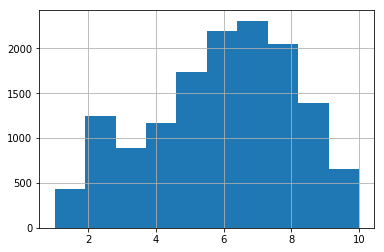

In [32]:
pd.Series(num_unique_sites).hist();

Теперь необходимо проверить с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально

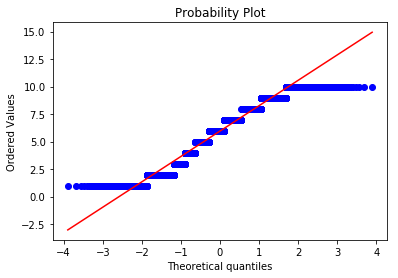

In [35]:
_ = stats.probplot(num_unique_sites, dist="norm", plot=plt)

 Число уникальных сайтов в сессии **не** распределено нормально.
 Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов, и вычислим p-value  описанной гипотезы

In [36]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test(sum(has_two_similar), len(has_two_similar), 0.95, alternative='greater')
print(pi_val)

0.0220765376907


Постройем распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

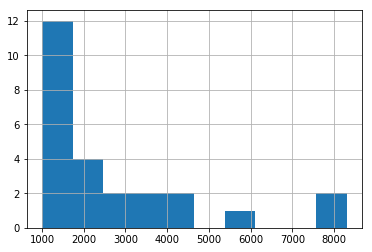

In [37]:
site_freq_path = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
with (open(site_freq_path, 'rb')) as file:
    site_freq = pickle.load(file)
site_freqs = [site_freq[s][1] for s in site_freq if site_freq[s][1] > 999]
pd.Series(site_freqs).hist();

## 3. Визуальный анализ данных построение признаков.

### Построение признаков

Создадим на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайдим следующие признаки:
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id*

In [1]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    with (open(site_freq_path, 'rb')) as file:
        site_freq = pickle.load(file)
    next_user_id = 1
    rows = []
    for file in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):
        data = pd.read_csv(file, parse_dates=['timestamp']) 
        sites = data.site.values
        session_count = int(len(sites) / window_size) + (1 if (len(sites) % window_size) != 0 else 0)
        for idx in range(0, session_count):  
            bound = min(idx *  window_size + session_length, len(sites))            
            current_session = [site_freq[s][0] for s in sites[idx * window_size : bound]]
            sessions_timestamps = [t for t in data.timestamp[idx * window_size : bound]]            
            seconds = (sessions_timestamps[len(sessions_timestamps) - 1] - sessions_timestamps[0]).seconds
            hour = sessions_timestamps[0].hour
            day = sessions_timestamps[0].dayofweek
            unique = len(set(current_session))            
            if len(current_session) < 10:
                current_session = current_session + [0] * (10 - len(current_session))           
            row = current_session + [seconds] + [unique] + [hour] + [day] + [next_user_id]
            rows.append(row)            
        next_user_id = next_user_id + 1    
    return pd.DataFrame(rows, columns=feature_names)

Применим функцию prepare_train_set_with_fe к данным по 10 и 150 пользователям

In [2]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'user_id']

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████| 150/150 [00:47<00:00,  4.00it/s]


Wall time: 54 s


Сохраним в pickle-файлы признаки session_timespan, #unique_sites, start_hour и day_of_week для 10 и 150 пользователей.

In [7]:
new_features_10users = train_data_10users[train_data_10users.columns[10:14]] 
new_features_150users = train_data_150users[train_data_150users.columns[10:14]] 

In [8]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

### Визуальный анализ данных

Присвоим пользователям имена и ассоциируем с ними цвета.

In [9]:
id_name_dict = {7: 'Mary-Kate', 3: 'Ashley', 8: 'Lindsey', 6: 'Naomi', 9: 'Avril',
               2: 'Bob', 4: 'Bill', 1: 'John', 5: 'Dick', 10: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [10]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

 Построим гистограмму распределения длины сессии в секундах (session_timespan). 

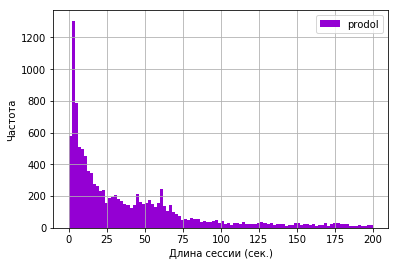

In [11]:
hist = train_data_10users['session_timespan'].hist(range=(0, 200), bins=100, color='darkviolet', label = 'prodol')
hist.set(xlabel=u'Длина сессии (сек.)', ylabel=u'Частота')
hist.legend()

Построим гистограмму распределения числа уникальных сайтов в сессии (#unique_sites). 

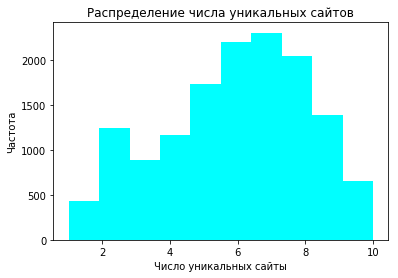

In [12]:
fig, ax = plt.subplots()
train_data_10users['#unique_sites'].plot(kind='hist', ax=ax, color='aqua')
ax.set_xlabel(u'Число уникальных сайты')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение числа уникальных сайтов');

 Построим гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности. 

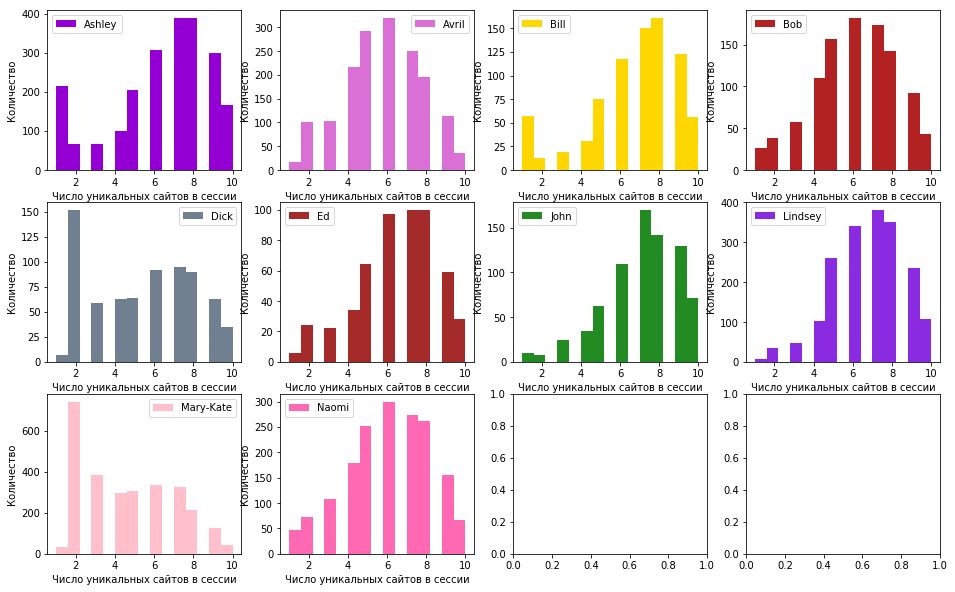

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes_flatten = axes.flatten()

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['#unique_sites'], bins=15, stacked=True, color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel=u'Число уникальных сайтов в сессии', ylabel=u'Количество')
    axes_flatten[idx].legend()

 Построим гистограмму распределения часа начала сессии (start_hour)

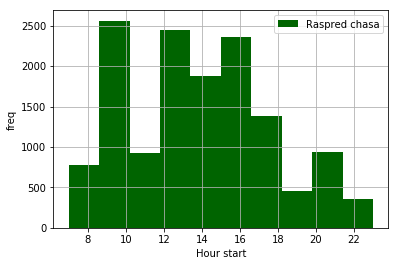

In [82]:
hist = train_data_10users['start_hour'].hist(bins=10, color='darkgreen', label = 'Raspred chasa')
hist.set(xlabel="Hour start", ylabel="freq")
hist.legend()

Построим гистограммы распределения часа начала сессии (start_hour) для каждого из 10 пользователей по отдельности.

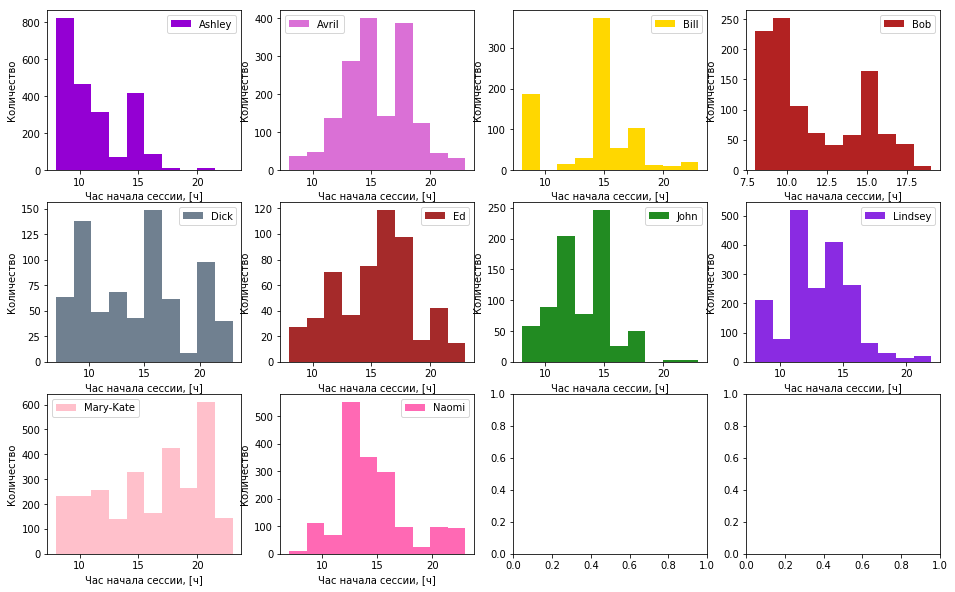

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes_flatten = axes.flatten()

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['start_hour'], bins=10, stacked=True, color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel=u'Час начала сессии, [ч]', ylabel=u'Количество')
    axes_flatten[idx].legend()

Построим гистограмму распределения дня недели, в который началась сессия (day_of_week). 

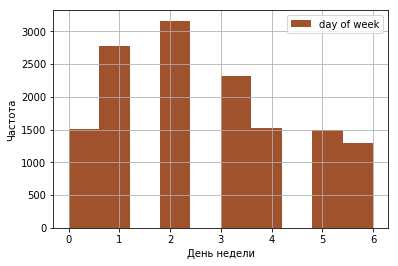

In [22]:
hist = train_data_10users['day_of_week'].hist(bins=10, color='sienna', label = 'day of week')
hist.set(xlabel=u'День недели', ylabel=u'Частота')
hist.legend()

Построим гистограммы распределения дня недели, в который началась сессия (day_of_week) для каждого из 10 пользователей по отдельности. 

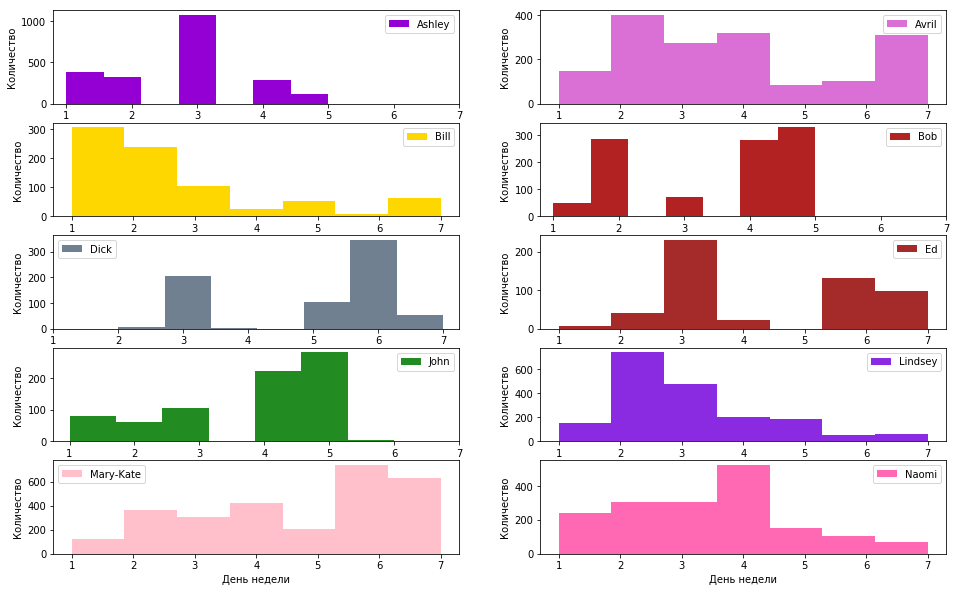

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 10))

axes_flatten = axes.flatten()
days = ['1', '2', '3', '4', '5', '6', '7']

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['day_of_week'], bins=7, align='mid', color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel=u'День недели', ylabel=u'Количество', xticklabels=days, xticks=np.arange(len(days)))
    axes_flatten[idx].legend()

По построенным графикам можно сделать следующие выводы:

* Все пользователи посещают примерно 6-8 различных сайтов за сессию
* Ashley: 8-9 уникальных сайтов за сессию; утром и в обед; только в будние дни (в среду пик активности)
* Пользователи значительно различаются по времени старта сессий, кто-то сидит в интернете больше по утрам, кто-то в течении всего дня (скорее всего это зависит от рода деятельности пользователя)
* John: 6-7 уникальных сайтов за сессию; в течение рабочего дня; в основном будние дни с увеличением к пятнице
* По гистограммам распределения дня начала сессии можно утверждать что пользователи  сидят в интернете больше в рабочие дни, чем в выходные.

Определим топ-10 самых посещаемых сайтов (top10_sites) и соответствующие кол-ва посещений (top10_freqs).

In [29]:
top10_sites = sorted(site_freq.keys(), key=lambda x: site_freq[x][1], reverse=True)[:10]
top10_freqs = [site_freq[s][1] for s in top10_sites]
print(zip(top10_sites, top10_freqs))

[('s.youtube.com', 8300), ('www.google.fr', 7813), ('www.google.com', 5441), ('mail.google.com', 4158), ('www.facebook.com', 4141), ('apis.google.com', 3758), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 3244), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 3094), ('plus.google.com', 2630), ('accounts.google.com', 2089)]


Нарисуем seaborn barplot, показывающий частоты посещений топ-10 сайтов.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

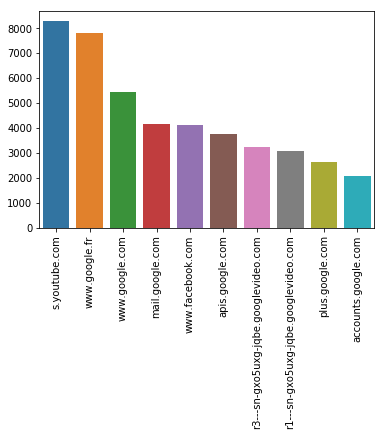

In [30]:
ax = sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90)

### Дальнейшее построение признаков

Напишем функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами.

In [48]:
def get_top(site_freq, token, top):
    count = Counter([x.split('.')[token:][0] for x in site_freq])
    return pd.Series(count).sort_values(ascending=False).index[:top]

In [49]:
def extract_part_of_day_and_season(date):
    part_of_day = 0
    season = 0    
    if date.hour > 1 and date.hour < 8:
        part_of_day = 1
    elif date.hour > 8 and date.hour < 18:
        part_of_day = 2
    else:
        part_of_day = 3
    season = 1 if date.month == 12 else date.month // 3 + 1        
    return part_of_day, season

In [52]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    with (open(site_freq_path, 'rb')) as file:
        site_freq = pickle.load(file)        
    first_level = get_top(site_freq, -1, 1)    
    second_level = get_top(site_freq, -2, 10)    
    top50_ids = [site_freq[s][0] for s in sorted(site_freq.keys(), key=lambda x: site_freq[x][1], reverse=True)[:50]]        
    next_user_id = 1
    rows = []    
    feature_names = ['average_time', 'popular_sites', 'fl', 'sl', 'part_of_day', 'season', 'user_id']    
    for file in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):
        data = pd.read_csv(file, parse_dates=['timestamp']) 
        sites = data.site.values        
        session_count = int(len(sites) / window_size) + (1 if (len(sites) % window_size) != 0 else 0)        
        for idx in range(0, session_count):            
            bound = min(idx *  window_size + session_length, len(sites))            
            current_session = sites[idx * window_size : bound]
            sessions_timestamps = [t for t in data.timestamp[idx * window_size : bound]]            
            counts_pop_sites = sum([site_freq[s][0] in top50_ids for s in current_session])
            avg = np.array([(sessions_timestamps[idx + 1] - sessions_timestamps[idx]).seconds \
                            for idx, _ in enumerate(sessions_timestamps) if idx + 1 != len(sessions_timestamps)]).mean()
            popular_first = sum([s.split('.')[-1:][0] in first_level for s in current_session])
            popular_second = sum([s.split('.')[-2:][0] in second_level for s in current_session])            
            part_of_day, season = extract_part_of_day_and_season(sessions_timestamps[0])           
            row = [avg, counts_pop_sites, popular_first, popular_second, part_of_day, season, next_user_id]
            rows.append(row)            
        next_user_id = next_user_id + 1    
    return pd.DataFrame(rows, columns=feature_names)

In [57]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  session_length=10)
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  session_length=10)

100%|████████████████████████████████████████| 150/150 [01:48<00:00,  1.72it/s]


Построим картинки для новых признаков, проведем их исследование

In [58]:
def hist(col, nrows=5, ncols=2, bins=10):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10))

    axes_flatten = axes.flatten()

    for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
        axes_flatten[idx].hist(sub_df[col], bins=bins, color = color_dic[id_name_dict[user]], label = id_name_dict[user])
        axes_flatten[idx].legend()

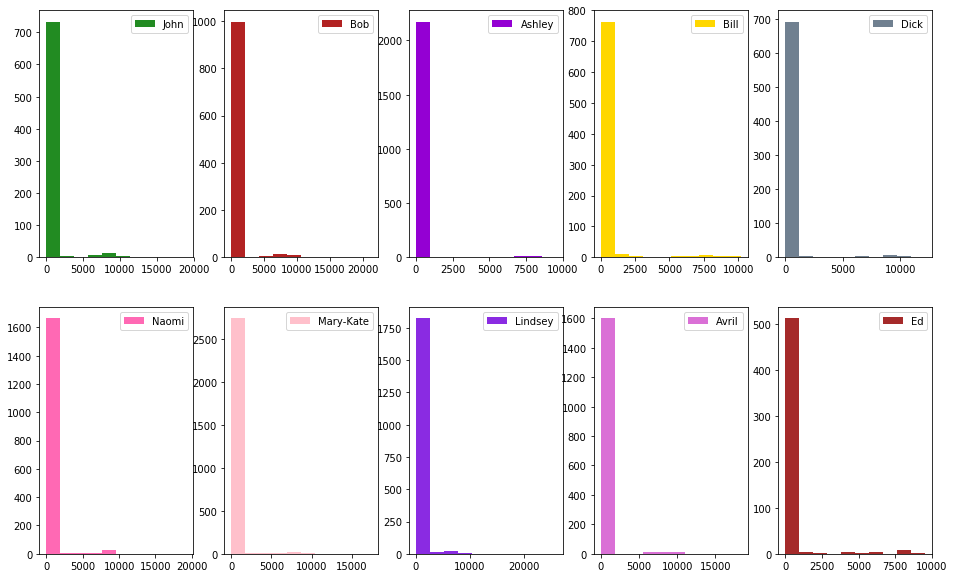

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 10))

axes_flatten = axes.flatten()

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['average_time'].dropna(), bins=10, color = color_dic[id_name_dict[user]], label = id_name_dict[user])
    axes_flatten[idx].legend()

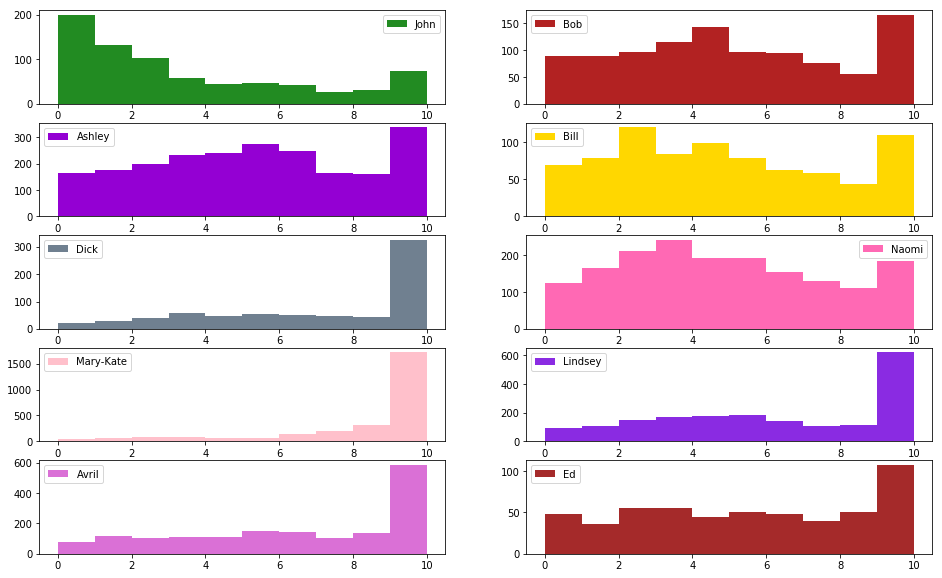

In [60]:
hist('popular_sites')

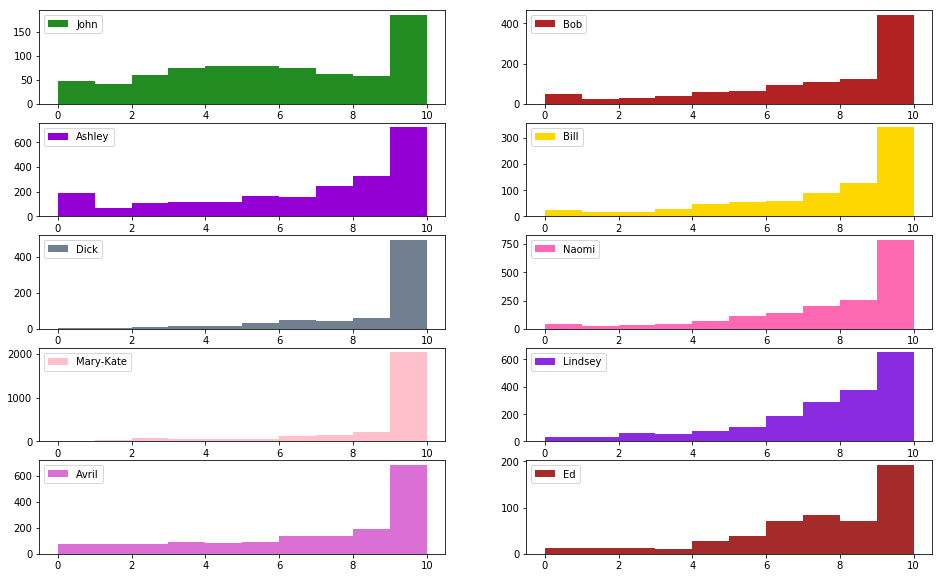

In [61]:
hist('fl')

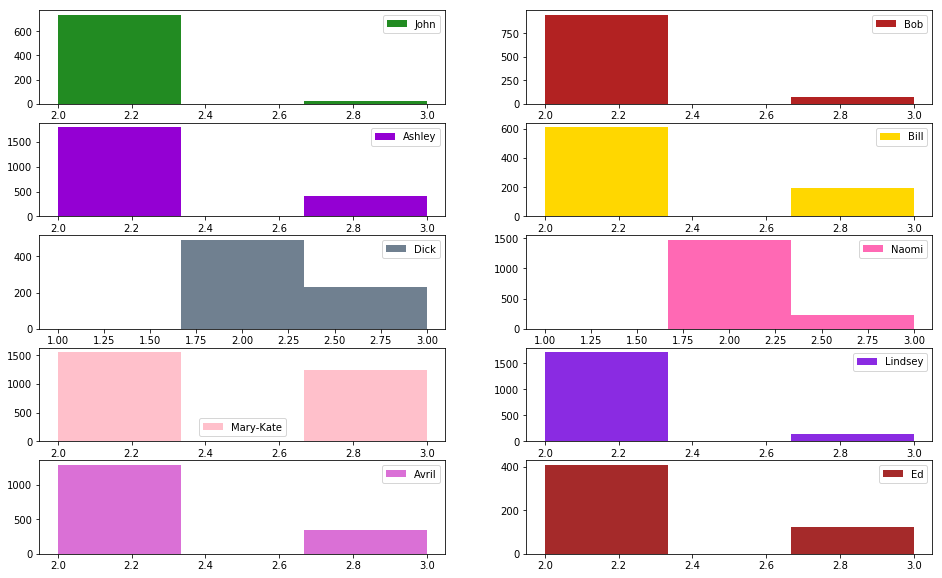

In [62]:
hist('part_of_day', bins=3)

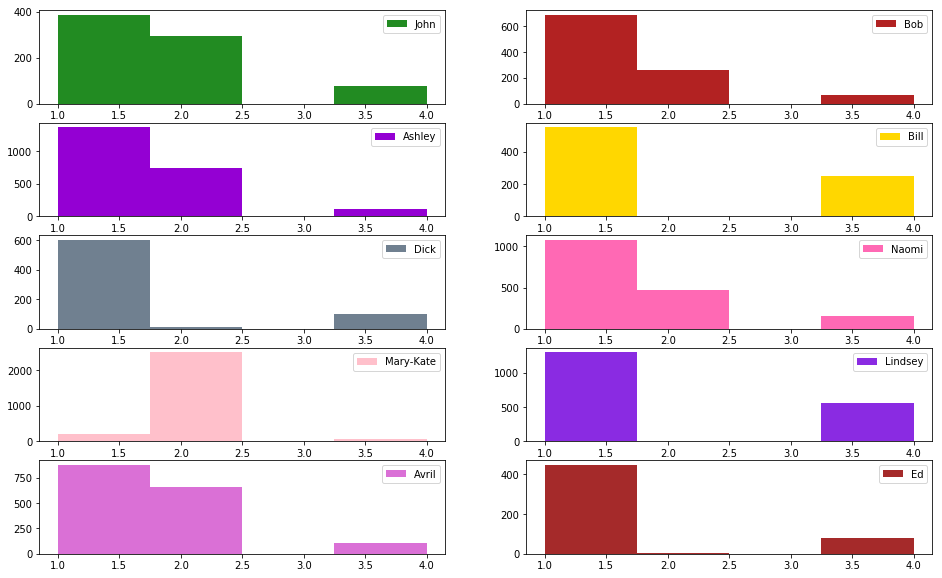

In [63]:
hist('season', bins=4)

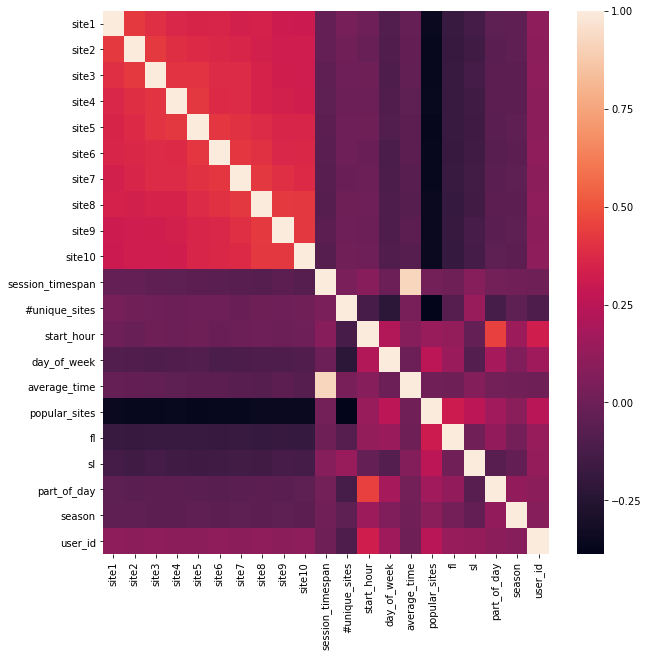

In [64]:
temp = pd.concat([train_data_10users[train_data_10users.columns[:-1]], new_features_10users], axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(temp.corr())

Из гистограмм видно, что маловероятно, что признак "Среднее время на сайт"е может принести пользу в обучении модели. А вот с остальными можно попробовать поработать, хотя по некоторым из них так же имеются большие сомнения. Так же следует отметить, что, как и ожидалось, среднее время проведенное на сайте илнейно зависимо от полного времени сессии

## 4. Сравнение алгоритмов классификации

### Сравнение нескольких алгоритмов на сессиях из 10 сайтов

In [66]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

In [68]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).

In [69]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Обучим KNeighborsClassifier со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только n_jobs=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) по выборке (X_train, y_train) и отдельно на выборке (X_valid, y_valid).

In [71]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1) 
score = cross_val_score(knn, X_train, y_train.astype('int'), cv=skf)
knn.fit(X_train, y_train.astype('int'))
pred = knn.predict(X_valid)
val_score = accuracy_score(y_valid.astype('int'), pred)

Обучим случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=17). Посмотрите на OOB-оценку (для этого надо сразу установить oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.

In [72]:
y_train = y_train.astype('int')
y_valid = y_valid.astype('int')
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)
oob_train = forest.oob_score_
oop_test = forest.score(X_valid, y_valid)

Обучим логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.

In [74]:
logit = LogisticRegression(random_state=17)
score = cross_val_score(logit, X_train, y_train, cv=skf)
logit.fit(X_train, y_train)
score_test = accuracy_score(y_valid, logit.predict(X_valid))


С помощью LogisticRegressionCV подберем параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используя logspace из NumPy. Укажем у LogisticRegressionCV параметры multi_class='multinomial' и random_state=17. Для кросс-валидации используем объект skf. Для распараллеливания зададим n_jobs=-1.

Нарисуем кривые валидации по параметру C.

In [75]:
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=17, cv=skf, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)
logit_mean_cv_scores1 = next (iter (logit_grid_searcher1.scores_.values())).mean(axis=0)
idx = np.where(logit_mean_cv_scores1==max(logit_mean_cv_scores1))[0][0]
print('C ', logit_grid_searcher1.Cs_[idx], ' : ', logit_mean_cv_scores1[idx])

C  1.0  :  0.758894091839


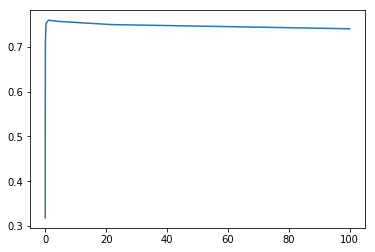

In [76]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

Обучим линейный SVM (LinearSVC) с параметром C=1 и random_state=17 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid).

In [77]:
svm = LinearSVC(C=1, random_state=17)
score = cross_val_score(svm, X_train, y_train, cv=skf)

С помощью GridSearchCV подберем параметр C для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используя linspace из NumPy. Нарисуем кривые валидации.

In [78]:
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(estimator=svm, param_grid=svm_params1)
svm_grid_searcher1.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   1.11111e+03,   2.22222e+03,   3.33333e+03,
         4.44444e+03,   5.55556e+03,   6.66667e+03,   7.77778e+03,
         8.88889e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

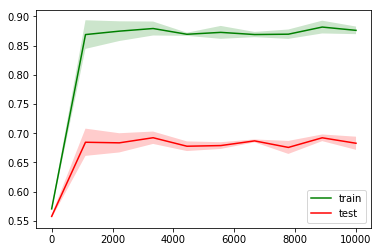

In [79]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

### Идентификация конкретного пользователя и кривые обучения

Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо.

Загрузим сериализованные ранее объекты X_sparse_150users и y_150users, соответствующие обучающей выборке для 150 пользователей с параметрами (session_length, window_size) = (10,10). Так же точно разобьем их на 70% и 30%.

In [90]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [91]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

In [92]:
logit_cv_150users = LogisticRegressionCV(Cs=[0.13879], multi_class='ovr', n_jobs=-1, random_state=17)
y_train_150 = y_train_150.astype('int')
logit_cv_150users.fit(X_train_150, y_train_150)

LogisticRegressionCV(Cs=[0.13879], class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=17,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.

In [93]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 1, CV score: 0.995391318841
User 2, CV score: 0.995996421663
User 3, CV score: 0.994880887618
User 4, CV score: 0.991210928449
User 5, CV score: 0.989458954529
User 6, CV score: 0.994578470355
User 7, CV score: 0.993337781052
User 8, CV score: 0.985528453269
User 9, CV score: 0.997768712011
User 10, CV score: 0.99442210693
User 11, CV score: 0.994192777373
User 12, CV score: 0.99339009849
User 13, CV score: 0.996934749889
User 14, CV score: 0.994974647742
User 15, CV score: 0.99636128288
User 16, CV score: 0.996277889477
User 17, CV score: 0.990355876892
User 18, CV score: 0.994213604299
User 19, CV score: 0.994734801323
User 20, CV score: 0.990866843289
User 21, CV score: 0.97874141854
User 22, CV score: 0.996507289738
User 23, CV score: 0.993692120565
User 24, CV score: 0.990136885965
User 25, CV score: 0.996288264931
User 26, CV score: 0.994046747263
User 27, CV score: 0.994839055058
User 28, CV score: 0.990188375257
User 29, CV score: 0.983996208357
User 30, CV score: 0.997257

## 5. Соревнование Kaggle Inclass по идентификации пользователей.

Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).

In [98]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [100]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [99]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.
Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.

In [101]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [102]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


* Добавим новые признаки: день недели начала сессии, час начала сессии, число уникальных сайтов в сессии, продолжительность нахождения на сайте для каждого этапа сессии.
* Сделаем разреженные матрицы X_train_sparse и X_test_sparse аналогично тому, как мы это делали ранее. Используем объединенную матрицу train_test_df_sites – потом разделим обратно на обучающую и тестовую части.
* Закодируем наши признаки, нормализуем их и объединим с исходными разреженными матрицами.
* Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.
* Создадим объект sklearn.linear_model.SGDClassifier с логистической функцией потерь, и будем подбирать оптимальные параметры для классификатора
* В качестве оценочной метрики будем пользоваться roc_auc_score.


### Применение Vowpal Wabbit к данным по посещению сайтов

Правда, в задаче нашего соревнования при бинарной классификации веб-сессий мы разницы не заметим – как по качеству, так и по скорости работы (хотя можете проверить), продемонстрируем всю резвость VW в задаче классификации на 400 классов. Исходные данные все те же самые, но выделено 400 пользователей, и решается задача их идентификации.
Vowpal Wabbit любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 550). Поэтому применим LabelEncoder, да еще и +1 добавим (LabelEncoder переводит метки в диапозон от 0 до K-1).

Реализуем функцию, arrays_to_vw, переводящую обучающую выборку в формат Vowpal Wabbit.

In [103]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):
    with open(os.path.join(PATH_TO_DATA, out_file), 'w') as out_vw:
        for i, row in enumerate(np.nditer(X, flags=['external_loop'], order='C')):
            arr_str = ' '.join(list(map(str, row)))
            if y is None:
                label = 1
            else:
                label = y[i]
            vw_str = '{} | {}'.format(label, arr_str)
            out_vw.write(vw_str + '\n')

* Применим написанную функцию к части обучащей выборки (train_df_part, y_train_part_for_vw), к отложенной выборке (valid_df, y_valid_for_vw), ко всей обучающей выборке и ко всей тестовой выборке. 
* Обучим модель на выборке kaggle_data/train_part.vw.
* Сделаем прогноз для тестовой выборки.
* Запишем прогноз в файл, примените обратное преобразование меток (был LabelEncoder и потом +1 в меткам)
- Знакомство с данной библиотекой показало огромный потенциал ее использования, но в какой-то степени не самый удобный интерфейс. Однако, хорошо знать об этом инструменте, который может пригодиться для решения других задач.


## Выводы

* В этом проекте была решена задача идентификации одного конкретного пользователя из множества других посредством обработки информации о его сессиях в интернете.
* Было проведено обучение моделей и сравнение полученных результатов. В просессе обучения были применены модели:LogisticRegression, LinearSVC, SGDClassifier. Лучшее качество было показано моделью LogisticRegression. Однако из минусов стоит отметить что эта модель достаточно долго обучается и не всегда сильно отличается по качеству.
* Первоначально нам необходимо было правильно идентифицировать одного пользователя. Эта задача свелась к классической задаче бинарной классификации, в которой был сильный дисбаланс классов. После генерации дополнительных признаков, их отбора, подбора параметров по сетке удалось получить очень неплохой результат на public leaderboard.
* В просессе прохождения курса была изучен новый tool Vowpal Wabbit, который достаточно быстро обучается и дает очень высокую точность предсказаний.
* Для малого количества пользователей(несколько десятков) линейные методы позволяют достаточно хорошо определить пользователя по набору его сессий.
* Задача классификации на 400 классов (идентификация 400 пользователей) решается недостаточно хорошо при честном отделении по времени тестовой выборки от обучающей.
Полученная модель может быть использована для распознавания конкретного пользователя по его сессиям в интернете.